The objective of this notebook is to run BOW and Multinomial Naive Bayes as our baseline model to have a reference in our experimentation


## Datasets

In [5]:
import pandas as pd
from mlflow.models import infer_signature
import warnings
warnings.filterwarnings('ignore')


train = pd.read_csv("../../data/gold/train.csv")
test = pd.read_csv("../../data/gold/test.csv")
val = pd.read_csv("../../data/gold/validation.csv")

X_train = train['features']
y_train = train['target']
X_test = test['features']
y_test = test['target']
signature = infer_signature(X_train, y_train)
X_train


0       hey next sun number there basic yoga course bu...
1                     dhoni luck win big titleso winemoji
2                                      really hows master
3                                see cup coffee animation
4                            pain couldnt come worse time
                              ...                        
4118       well boy glad g wasted night applebees nothing
4119    want number get laid tonight want real dogging...
4120                                            thanx lot
4121                             well ball time make call
4122    see knew giving break time woul lead always wa...
Name: features, Length: 4123, dtype: object

## Augmentation (SMOTE)

In [6]:

from imblearn.over_sampling import SMOTE

In [7]:
smote = SMOTE(sampling_strategy='minority', random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)


ValueError: could not convert string to float: 'hey next sun number there basic yoga course bugis go pilate intro next sat tell time r free'

## Synonims Replacement

In [2]:
from nltk.corpus import stopwords, wordnet 
stop_words = set(stopwords.words('english'))
import random
from random import shuffle
random.seed(1)

In [3]:
# stop_words = ['i', 'me', 'my', 'myself', 'we', 'our', 
# 			'ours', 'ourselves', 'you', 'your', 'yours', 
# 			'yourself', 'yourselves', 'he', 'him', 'his', 
# 			'himself', 'she', 'her', 'hers', 'herself', 
# 			'it', 'its', 'itself', 'they', 'them', 'their', 
# 			'theirs', 'themselves', 'what', 'which', 'who', 
# 			'whom', 'this', 'that', 'these', 'those', 'am', 
# 			'is', 'are', 'was', 'were', 'be', 'been', 'being', 
# 			'have', 'has', 'had', 'having', 'do', 'does', 'did',
# 			'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or',
# 			'because', 'as', 'until', 'while', 'of', 'at', 
# 			'by', 'for', 'with', 'about', 'against', 'between',
# 			'into', 'through', 'during', 'before', 'after', 
# 			'above', 'below', 'to', 'from', 'up', 'down', 'in',
# 			'out', 'on', 'off', 'over', 'under', 'again', 
# 			'further', 'then', 'once', 'here', 'there', 'when', 
# 			'where', 'why', 'how', 'all', 'any', 'both', 'each', 
# 			'few', 'more', 'most', 'other', 'some', 'such', 'no', 
# 			'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 
# 			'very', 's', 't', 'can', 'will', 'just', 'don', 
# 			'should', 'now', '']

In [4]:
def get_synonyms(word):
    synonyms = set()
    for syn in wordnet.synsets(word): 
        for l in syn.lemmas(): 
            synonym = l.name().replace("_", " ").replace("-", " ").lower()
            synonym = "".join([char for char in synonym if char in ' qwertyuiopasdfghjklzxcvbnm'])
            synonyms.add(synonym) 
    if word in synonyms:
        synonyms.remove(word)
    return list(synonyms)

In [5]:
def synonym_replacement(sentence, n):
    words = sentence.split(' ')
    new_words = words.copy()
    random_word_list = list(set([word for word in words if word not in stop_words]))
    random.shuffle(random_word_list)
    num_replaced = 0
    for random_word in random_word_list:
        synonyms = get_synonyms(random_word)
        if len(synonyms) >= 1:
            synonym = random.choice(list(synonyms))
            new_words = [synonym if word == random_word else word for word in new_words]
            num_replaced += 1
        if num_replaced >= n:  
            break

    return ' '.join(new_words)

In [8]:
def apply_synonym_replacement_to_series(X_train, n):
    return X_train.apply(lambda x: synonym_replacement(x, n))

# Supón que tienes X_train como una Serie de pandas
X_train = apply_synonym_replacement_to_series(X_train, 5)


## Pipeline

In [9]:
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    fbeta_score,
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    precision_recall_curve,
    auc,
    balanced_accuracy_score,
)


pipeline = Pipeline([
        ('vectorizer', CountVectorizer(ngram_range=(1, 1), max_features=None)),
        ('classifier', MultinomialNB())
    ])
    
pipeline.fit(X_train, y_train)
y_test_pred = pipeline.predict(X_test)


In [10]:
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Accuracy: {test_accuracy:.2f} ")

Accuracy: 0.97 


Notes: 

As expected our model has a high accuracy that doesn't mean much since the dataset is imbalanced

In [11]:
balanced_accuracy = balanced_accuracy_score(y_test, y_test_pred)
print(f"Balanced Accuracy: {balanced_accuracy:.2f}")

Balanced Accuracy: 0.95


Notes: 

The model is correctly identifying both spam and non-spam messages with a high level of recall.

In [12]:
# F0.5-Score
f0_5_score = fbeta_score(y_test, y_test_pred, beta=0.5)
print(f"F0.5-Score: {f0_5_score:.2f}")

F0.5-Score: 0.87


In [13]:
report = classification_report(y_test, y_test_pred)
print("Classification Report (Test Data):")
print(report)

Classification Report (Test Data):
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       453
           1       0.85      0.92      0.89        63

    accuracy                           0.97       516
   macro avg       0.92      0.95      0.93       516
weighted avg       0.97      0.97      0.97       516



Notes:

- f0.5-score: the metric chosen since I want to give more important to the false positives. A value of 0.85 indicates good performance of the model. 
- Precision: 82% of the predicted positives are true positives. Good performance.
- Recall: 95% of the real positives are true positives. Good performance.
- F1-score: the model is doing a decent job but since the dataset is imbalanced and I want to focus on the false positives, I take it with a grain of salt. 
- Accuracy and macro avg can be ignored.
- Weighted avgs: they also look good but we have to remember that depending on the disbalance of our dataset, these values can hide issues.  

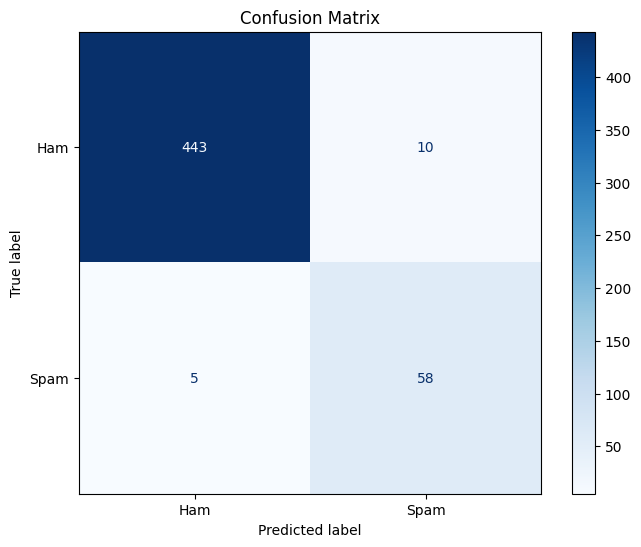

In [14]:
test_conf_matrix = confusion_matrix(y_test, y_test_pred)
matrix_fig, ax = plt.subplots(figsize=(8, 6))
cm_display = ConfusionMatrixDisplay(confusion_matrix=test_conf_matrix, display_labels=['Ham', 'Spam'])
cm_display.plot(cmap='Blues', ax=ax)
plt.title("Confusion Matrix")
plt.show()

Notes:

The confusion matrix looks very good.
- 13 e-mails were predicted as SPAM but they were HAM. (these are the ones I will try to minimize)
- 3 e-mails were predicted as HAM but they were SPAM.

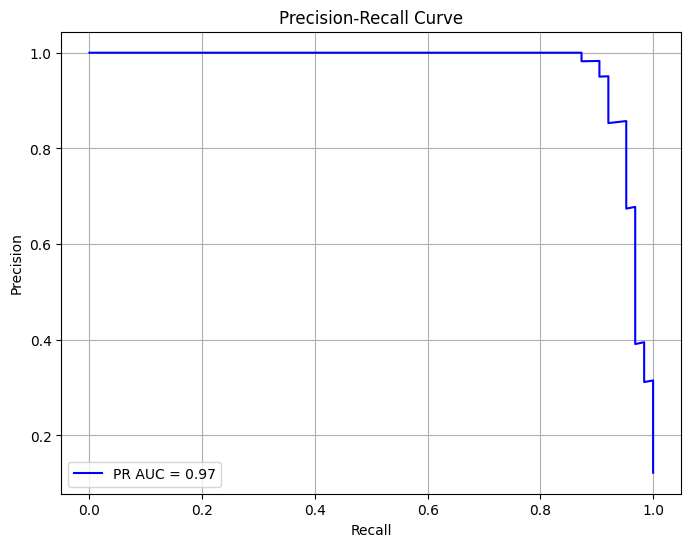

In [15]:
y_test_pred_prob = pipeline.predict_proba(X_test)[:, 1]

precision, recall, _ = precision_recall_curve(y_test, y_test_pred_prob)
pr_auc = auc(recall, precision)

pr_fig, ax = plt.subplots(figsize=(8, 6))  
ax.plot(recall, precision, color='b', label=f'PR AUC = {pr_auc:.2f}')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('Precision-Recall Curve')
ax.legend(loc="best")
ax.grid(True)
plt.show()


Notes: 

The area under the curve is 0.96 so the model strikes a strong balance between precision and recall across thresholds. The model identifies spam effectively without producing excessive false positives.

In [ ]:
grtthrty

## MLFlow configuration

In [ ]:
from experiments_utils import experiment_status
import mlflow

In [ ]:
from experiments_utils import experiment_status
import mlflow

In [ ]:
# on the console
# mlflow server --backend-store-uri sqlite:///backend.db --default-artifact-root ./artifacts


mlflow.set_tracking_uri("http://127.0.0.1:5000")
# mlflow.search_experiments()

In [ ]:
experiment_status()

('NLP-text-classifier',
 'This experiment contains mlruns for different approaches in the ml lifecycle of an e-mail spam detector classifier.',
 {'project_name': 'spam-classifier',
  'project_stage': 'testing',
  'team': 'ml-team',
  'project_quarter': 'Q4-2024'})

In [ ]:
# from mlflow.tracking import MlflowClient
# client = MlflowClient()
# client.delete_run("81b0d40ddc814076a95bc6fd9d4fff34")

In [ ]:
from experiments_utils import experiment_status
import mlflow

In [ ]:
# on the console
# mlflow server --backend-store-uri sqlite:///backend.db --default-artifact-root ./artifacts


mlflow.set_tracking_uri("http://127.0.0.1:5000")
# mlflow.search_experiments()

In [ ]:
experiment_status()

('NLP-text-classifier',
 'This experiment contains mlruns for different approaches in the ml lifecycle of an e-mail spam detector classifier.',
 {'project_name': 'spam-classifier',
  'project_stage': 'testing',
  'team': 'ml-team',
  'project_quarter': 'Q4-2024'})

In [ ]:
# from mlflow.tracking import MlflowClient
# client = MlflowClient()
# client.delete_run("81b0d40ddc814076a95bc6fd9d4fff34")

In [ ]:
from experiments_utils import experiment_status
import mlflow

In [ ]:
# on the console
# mlflow server --backend-store-uri sqlite:///backend.db --default-artifact-root ./artifacts


mlflow.set_tracking_uri("http://127.0.0.1:5000")
# mlflow.search_experiments()

In [ ]:
experiment_status()

('NLP-text-classifier',
 'This experiment contains mlruns for different approaches in the ml lifecycle of an e-mail spam detector classifier.',
 {'project_name': 'spam-classifier',
  'project_stage': 'testing',
  'team': 'ml-team',
  'project_quarter': 'Q4-2024'})

In [ ]:
# from mlflow.tracking import MlflowClient
# client = MlflowClient()
# client.delete_run("81b0d40ddc814076a95bc6fd9d4fff34")

In [ ]:
from experiments_utils import experiment_status
import mlflow

In [ ]:
# on the console
# mlflow server --backend-store-uri sqlite:///backend.db --default-artifact-root ./artifacts


mlflow.set_tracking_uri("http://127.0.0.1:5000")
# mlflow.search_experiments()

In [ ]:
experiment_status()

('NLP-text-classifier',
 'This experiment contains mlruns for different approaches in the ml lifecycle of an e-mail spam detector classifier.',
 {'project_name': 'spam-classifier',
  'project_stage': 'testing',
  'team': 'ml-team',
  'project_quarter': 'Q4-2024'})

In [ ]:
# from mlflow.tracking import MlflowClient
# client = MlflowClient()
# client.delete_run("81b0d40ddc814076a95bc6fd9d4fff34")

In [ ]:
from experiments_utils import experiment_status
import mlflow

In [ ]:
# on the console
# mlflow server --backend-store-uri sqlite:///backend.db --default-artifact-root ./artifacts


mlflow.set_tracking_uri("http://127.0.0.1:5000")
# mlflow.search_experiments()

In [ ]:
experiment_status()

('NLP-text-classifier',
 'This experiment contains mlruns for different approaches in the ml lifecycle of an e-mail spam detector classifier.',
 {'project_name': 'spam-classifier',
  'project_stage': 'testing',
  'team': 'ml-team',
  'project_quarter': 'Q4-2024'})

In [ ]:
# from mlflow.tracking import MlflowClient
# client = MlflowClient()
# client.delete_run("81b0d40ddc814076a95bc6fd9d4fff34")

In [ ]:
from experiments_utils import experiment_status
import mlflow

In [ ]:
# on the console
# mlflow server --backend-store-uri sqlite:///backend.db --default-artifact-root ./artifacts


mlflow.set_tracking_uri("http://127.0.0.1:5000")
# mlflow.search_experiments()

In [ ]:
experiment_status()

('NLP-text-classifier',
 'This experiment contains mlruns for different approaches in the ml lifecycle of an e-mail spam detector classifier.',
 {'project_name': 'spam-classifier',
  'project_stage': 'testing',
  'team': 'ml-team',
  'project_quarter': 'Q4-2024'})

In [ ]:
# from mlflow.tracking import MlflowClient
# client = MlflowClient()
# client.delete_run("81b0d40ddc814076a95bc6fd9d4fff34")

In [ ]:
from experiments_utils import experiment_status
import mlflow

In [ ]:
# on the console
# mlflow server --backend-store-uri sqlite:///backend.db --default-artifact-root ./artifacts


mlflow.set_tracking_uri("http://127.0.0.1:5000")
# mlflow.search_experiments()

In [ ]:
experiment_status()

('NLP-text-classifier',
 'This experiment contains mlruns for different approaches in the ml lifecycle of an e-mail spam detector classifier.',
 {'project_name': 'spam-classifier',
  'project_stage': 'testing',
  'team': 'ml-team',
  'project_quarter': 'Q4-2024'})

In [ ]:
# from mlflow.tracking import MlflowClient
# client = MlflowClient()
# client.delete_run("81b0d40ddc814076a95bc6fd9d4fff34")

In [ ]:
from experiments_utils import experiment_status
import mlflow

In [ ]:
# on the console
# mlflow server --backend-store-uri sqlite:///backend.db --default-artifact-root ./artifacts


mlflow.set_tracking_uri("http://127.0.0.1:5000")
# mlflow.search_experiments()

In [ ]:
experiment_status()

('NLP-text-classifier',
 'This experiment contains mlruns for different approaches in the ml lifecycle of an e-mail spam detector classifier.',
 {'project_name': 'spam-classifier',
  'project_stage': 'testing',
  'team': 'ml-team',
  'project_quarter': 'Q4-2024'})

In [ ]:
# from mlflow.tracking import MlflowClient
# client = MlflowClient()
# client.delete_run("81b0d40ddc814076a95bc6fd9d4fff34")

In [ ]:
from experiments_utils import experiment_status
import mlflow

In [ ]:
# on the console
# mlflow server --backend-store-uri sqlite:///backend.db --default-artifact-root ./artifacts


mlflow.set_tracking_uri("http://127.0.0.1:5000")
# mlflow.search_experiments()

In [ ]:
experiment_status()

('NLP-text-classifier',
 'This experiment contains mlruns for different approaches in the ml lifecycle of an e-mail spam detector classifier.',
 {'project_name': 'spam-classifier',
  'project_stage': 'testing',
  'team': 'ml-team',
  'project_quarter': 'Q4-2024'})

In [ ]:
# from mlflow.tracking import MlflowClient
# client = MlflowClient()
# client.delete_run("81b0d40ddc814076a95bc6fd9d4fff34")

In [ ]:
from experiments_utils import experiment_status
import mlflow

In [ ]:
# on the console
# mlflow server --backend-store-uri sqlite:///backend.db --default-artifact-root ./artifacts


mlflow.set_tracking_uri("http://127.0.0.1:5000")
# mlflow.search_experiments()

In [ ]:
experiment_status()

('NLP-text-classifier',
 'This experiment contains mlruns for different approaches in the ml lifecycle of an e-mail spam detector classifier.',
 {'project_name': 'spam-classifier',
  'project_stage': 'testing',
  'team': 'ml-team',
  'project_quarter': 'Q4-2024'})

In [ ]:
# from mlflow.tracking import MlflowClient
# client = MlflowClient()
# client.delete_run("81b0d40ddc814076a95bc6fd9d4fff34")

In [ ]:
from experiments_utils import experiment_status
import mlflow

In [ ]:
# on the console
# mlflow server --backend-store-uri sqlite:///backend.db --default-artifact-root ./artifacts


mlflow.set_tracking_uri("http://127.0.0.1:5000")
# mlflow.search_experiments()

In [ ]:
experiment_status()

('NLP-text-classifier',
 'This experiment contains mlruns for different approaches in the ml lifecycle of an e-mail spam detector classifier.',
 {'project_name': 'spam-classifier',
  'project_stage': 'testing',
  'team': 'ml-team',
  'project_quarter': 'Q4-2024'})

In [ ]:
# from mlflow.tracking import MlflowClient
# client = MlflowClient()
# client.delete_run("81b0d40ddc814076a95bc6fd9d4fff34")

In [ ]:
from experiments_utils import experiment_status
import mlflow

In [ ]:
# on the console
# mlflow server --backend-store-uri sqlite:///backend.db --default-artifact-root ./artifacts


mlflow.set_tracking_uri("http://127.0.0.1:5000")
# mlflow.search_experiments()

In [ ]:
experiment_status()

('NLP-text-classifier',
 'This experiment contains mlruns for different approaches in the ml lifecycle of an e-mail spam detector classifier.',
 {'project_name': 'spam-classifier',
  'project_stage': 'testing',
  'team': 'ml-team',
  'project_quarter': 'Q4-2024'})

In [ ]:
# from mlflow.tracking import MlflowClient
# client = MlflowClient()
# client.delete_run("81b0d40ddc814076a95bc6fd9d4fff34")

In [ ]:
from experiments_utils import experiment_status
import mlflow

In [ ]:
# on the console
# mlflow server --backend-store-uri sqlite:///backend.db --default-artifact-root ./artifacts


mlflow.set_tracking_uri("http://127.0.0.1:5000")
# mlflow.search_experiments()

In [ ]:
experiment_status()

('NLP-text-classifier',
 'This experiment contains mlruns for different approaches in the ml lifecycle of an e-mail spam detector classifier.',
 {'project_name': 'spam-classifier',
  'project_stage': 'testing',
  'team': 'ml-team',
  'project_quarter': 'Q4-2024'})

In [ ]:
# from mlflow.tracking import MlflowClient
# client = MlflowClient()
# client.delete_run("81b0d40ddc814076a95bc6fd9d4fff34")

In [ ]:
from experiments_utils import experiment_status
import mlflow

In [ ]:
# on the console
# mlflow server --backend-store-uri sqlite:///backend.db --default-artifact-root ./artifacts


mlflow.set_tracking_uri("http://127.0.0.1:5000")
# mlflow.search_experiments()

In [ ]:
experiment_status()

('NLP-text-classifier',
 'This experiment contains mlruns for different approaches in the ml lifecycle of an e-mail spam detector classifier.',
 {'project_name': 'spam-classifier',
  'project_stage': 'testing',
  'team': 'ml-team',
  'project_quarter': 'Q4-2024'})

In [ ]:
# from mlflow.tracking import MlflowClient
# client = MlflowClient()
# client.delete_run("81b0d40ddc814076a95bc6fd9d4fff34")

In [ ]:
from experiments_utils import experiment_status
import mlflow

In [ ]:
# on the console
# mlflow server --backend-store-uri sqlite:///backend.db --default-artifact-root ./artifacts


mlflow.set_tracking_uri("http://127.0.0.1:5000")
# mlflow.search_experiments()

In [ ]:
experiment_status()

('NLP-text-classifier',
 'This experiment contains mlruns for different approaches in the ml lifecycle of an e-mail spam detector classifier.',
 {'project_name': 'spam-classifier',
  'project_stage': 'testing',
  'team': 'ml-team',
  'project_quarter': 'Q4-2024'})

In [ ]:
# from mlflow.tracking import MlflowClient
# client = MlflowClient()
# client.delete_run("81b0d40ddc814076a95bc6fd9d4fff34")

In [ ]:
# on the console
# mlflow server --backend-store-uri sqlite:///backend.db --default-artifact-root ./artifacts


mlflow.set_tracking_uri("http://127.0.0.1:5000")
# mlflow.search_experiments()

In [ ]:
experiment_status()

('NLP-text-classifier',
 'This experiment contains mlruns for different approaches in the ml lifecycle of an e-mail spam detector classifier.',
 {'project_name': 'spam-classifier',
  'project_stage': 'testing',
  'team': 'ml-team',
  'project_quarter': 'Q4-2024'})

In [ ]:
# from mlflow.tracking import MlflowClient
# client = MlflowClient()
# client.delete_run("81b0d40ddc814076a95bc6fd9d4fff34")

In [ ]:
from experiments_utils import experiment_status
import mlflow

In [ ]:
# on the console
# mlflow server --backend-store-uri sqlite:///backend.db --default-artifact-root ./artifacts


mlflow.set_tracking_uri("http://127.0.0.1:5000")
# mlflow.search_experiments()

In [ ]:
experiment_status()

('NLP-text-classifier',
 'This experiment contains mlruns for different approaches in the ml lifecycle of an e-mail spam detector classifier.',
 {'project_name': 'spam-classifier',
  'project_stage': 'testing',
  'team': 'ml-team',
  'project_quarter': 'Q4-2024'})

In [ ]:
# from mlflow.tracking import MlflowClient
# client = MlflowClient()
# client.delete_run("81b0d40ddc814076a95bc6fd9d4fff34")

## MLFlow config


In [ ]:
from experiments_utils import experiment_status
import mlflow

import os
mlflow.set_tracking_uri("http://127.0.0.1:5000")
experiment_status()

('spam-classifier',
 'This experiment contains mlruns for different approaches in the ml lifecycle of an e-mail spam detector classifier.',
 {'project_name': 'NLP-text-classifier',
  'project_stage': 'testing',
  'team': 'ml-team',
  'project_quarter': 'Q4-2024'})

In [ ]:
# on the console
# mlflow server --backend-store-uri sqlite:///backend.db --default-artifact-root ./artifacts
# mlflow.search_experiments()

# from mlflow.tracking import MlflowClient
# client = MlflowClient()
# client.delete_run("81b0d40ddc814076a95bc6fd9d4fff34")

In [ ]:
experiment_name, _, _ = experiment_status()
mlflow.set_experiment(experiment_name)

<Experiment: artifact_location='/home/maldu/dscience/projects/spam_detector/notebooks/experimentation/artifacts/1', creation_time=1733501883396, experiment_id='1', last_update_time=1733501883396, lifecycle_stage='active', name='spam-classifier', tags={}>

## MlFlow tracking

In [ ]:
   
with mlflow.start_run(run_name="baseline-model", log_system_metrics=True) as run:
    
    # Tags
    mlflow.set_tag("dataset", "Spam detection")
    mlflow.set_tag("task", "classification")
    mlflow.set_tag("vectorizer", "CountVectorizer")
    mlflow.set_tag("algorithm", "Multinomial Naive Bayes")
    mlflow.set_tag("framework", "Scikit-learn")
    mlflow.set_tag("language", "Python")
    mlflow.set_tag("environment", "Local")
    mlflow.set_tag("dataset_version", "1.0.0")
    mlflow.set_tag("preprocessing_version", "1.0.0")
    mlflow.set_tag("model_version", "0.0.1")
    mlflow.set_tag("developer", "Mldu")
    mlflow.set_tag("project_stage", "testing")

    #Datasets
    mlflow.log_input(mlflow.data.from_pandas(train, name="train dataset", targets="target"))
    mlflow.log_input(mlflow.data.from_pandas(test, name="test dataset", targets="target"))
    mlflow.log_input(mlflow.data.from_pandas(val, name="validation dataset", targets="target"))
    mlflow.log_artifact("../../data/gold/train.csv")
    mlflow.log_artifact("../../data/gold/test.csv")
    mlflow.log_artifact("../../data/gold/validation.csv")

    
    #BOW and model
    mlflow.log_param("vectorizer_type", "CountVectorizer")
    mlflow.log_param("model_type", "MultinomialNB")
    
    # Metrics
    mlflow.log_metric("test_accuracy", test_accuracy)
    mlflow.log_metric("balanced_accuracy", balanced_accuracy)
    mlflow.log_metric("f0_5_score", f0_5_score)
    cr = classification_report(y_test, y_test_pred, output_dict=True)
    mlflow.log_metric("accuracy", cr.pop("accuracy"))
    for class_or_avg, metrics_dict in cr.items():
        for metric, value in metrics_dict.items():
            mlflow.log_metric(class_or_avg + '_' + metric,value)
    
    # Figures
    mlflow.log_figure(matrix_fig, "confusion-matrix.png")
    mlflow.log_figure(pr_fig, "precision-recall-curve.png")
    
    # CountVectorizer and MNB
    mlflow.sklearn.log_model(pipeline, "pipeline",signature=signature)
    
    # Notebook's name as tag and save as artifact
    notebook_name = os.path.basename(globals()['__vsc_ipynb_file__'])   
    mlflow.set_tag("source_notebook", f"{notebook_name}")
    mlflow.log_artifact(f"{notebook_name}", artifact_path="notebooks")


    print(f"Pipeline logged to MLflow under run ID {run.info.run_id}")

2024/12/06 18:26:22 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.


2024/12/06 18:26:24 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/12/06 18:26:24 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!


Pipeline logged to MLflow under run ID 15ebd7bdd63b48ec84ca2de4ac49b9aa
🏃 View run baseline-model at: http://127.0.0.1:5000/#/experiments/1/runs/15ebd7bdd63b48ec84ca2de4ac49b9aa
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1


Conclusions:

- Clear overfitting 
- The model is not predicting at random since the accuracy is higher than the imbalance